# Emdedding을 사용한 문장 분류

copy from https://www.tensorflow.org/beta/tutorials/text/word_embeddings

In [0]:
!pip install -q tensorflow-gpu==2.0.0-beta1


In [0]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [0]:
print(tf.__version__)

2.0.0-beta1


## Embedding Layer

Embedding(input_dim, output_dim)

input.shape : (batch_size, sequence_length)

output.shape : (batch_size, sequence_length, output_dim)

```
model.add(Embedding(1000, 32)) # 단어의 갯수가 1000개, 임베딩된 결과가 32차원 백터
```

입력은 고정된 갯수(sequence_length)의 숫자
 
출력은 입력 각 숫자마다 임베딩된 숫자들

```
원 text = [ cat dog horse ]
input =  [ 123, 234, 456 ] # 123: cat의 사전 인덱스

output
[1 0 1 0] # 임베딩된 123
[0 0 1 1] # 임베딩된 234
[1 1 1 0] # 임베딩된 456

```



## IMDB

Internet Movie DB

영화리뷰. y는 긍정/부정의 1 or 0

In [0]:
vocab_size = 10000
imdb = keras.datasets.imdb
(train_x, train_y), (test_x, test_y) = imdb.load_data(num_words=vocab_size)

In [0]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

print(train_x[0])
print(len(train_x[0]))
print(train_x[1])
print(len(train_x[1]))

print(train_y[:20])


(25000,)
(25000,)
(25000,)
(25000,)
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
218
[1, 194, 1153, 194, 

In [0]:
# numpy는 길이가 서로 다른 리스트들을 요소로 가지고 있을 수 있다.
import numpy as np
a = np.array([[1,2,3], [4,5,6,7,8,9]])
print(a.shape)
print(type(a[0]))
print(type(a[1]))



(2,)
<class 'list'>
<class 'list'>


## 사전 생성

- word_index : 단어 -> 인덱스
- reverse_word_index : 인덱스 -> 단어



In [0]:
word_index = imdb.get_word_index()
# word_index = {'fawn': 34701, 'tsukino': 52006, ... }


# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()}
# word_index = {'fawn': 34701+3, 'tsukino': 52006+3, ... }

word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3
# word_index = {'<PAD>':0, '<START>':1, '<UNK>':2, '<UNUSED>':3, fawn': 34701+3, 'tsukino': 52006+3, ... }

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# reverse_word_index = {0:'<PAD>', 1:'<START>', 2:'<UNK>', 3:'<UNUSED>', 34701+3:'fawn', 52006+3:'tsukino', ... }

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_review(train_x[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## 고정 길이로 데이터 변경


각기 다른 길이의 train_x를 고정된 길이 500으로 만듬

In [0]:
from keras.preprocessing import sequence

maxlen = 500

# 모든 데이터를 길이 500으로 만듬. "<PAD>"에 해당하는 0으로 채워 넣음
train_x = sequence.pad_sequences(
    train_x,
    value=word_index["<PAD>"],
    padding='post',
    maxlen=maxlen
)

test_x = sequence.pad_sequences(
    test_x,
    value=word_index["<PAD>"],
    padding='post',
    maxlen=maxlen
)

print(train_x[0])

Using TensorFlow backend.


[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## 모델 생성

500(maxlen)길의의 문장을 입력으로 받아 긍정 or 부정으로 분류한다.

첫번 째 Dense 레이어는 500길이 숫자로 표시된 문장을 16(embedding_dim)의 벡터로 변환(임베딩)한다.

뒤의 2개의 Dense 레이어는 16개의 숫자로 1 or 0으로 분류한다.

In [0]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


## 컴파일과 학습

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_x,
    train_y,
    epochs=30,
    batch_size=512,
    validation_split=0.2)

W0724 17:00:48.140688 140202756298624 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 2s 95us/sample - loss: 0.6922 - accuracy: 0.5422 - val_loss: 0.6910 - val_accuracy: 0.4956
Epoch 2/30
20000/20000 [==============================] - 1s 42us/sample - loss: 0.6877 - accuracy: 0.5742 - val_loss: 0.6835 - val_accuracy: 0.6842
Epoch 3/30
20000/20000 [==============================] - 1s 40us/sample - loss: 0.6764 - accuracy: 0.6908 - val_loss: 0.6676 - val_accuracy: 0.7300
Epoch 4/30
20000/20000 [==============================] - 1s 39us/sample - loss: 0.6548 - accuracy: 0.7404 - val_loss: 0.6405 - val_accuracy: 0.7644
Epoch 5/30
20000/20000 [==============================] - 1s 39us/sample - loss: 0.6210 - accuracy: 0.7821 - val_loss: 0.6011 - val_accuracy: 0.7822
Epoch 6/30
20000/20000 [==============================] - 1s 40us/sample - loss: 0.5757 - accuracy: 0.8049 - val_loss: 0.5546 - val_accuracy: 0.8076
Epoch 7/30
20000/20000 [==============================] -

## 학습된 경과 보기

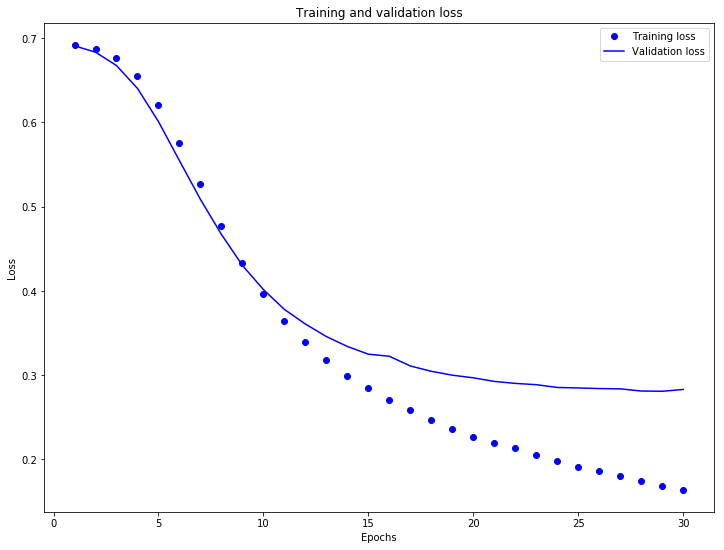

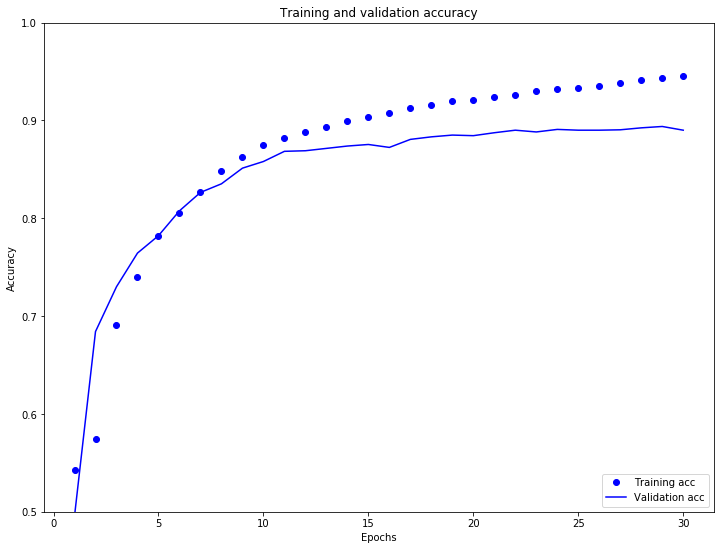

In [0]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

## 학습된 엠베딩 레이어 저장

In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [0]:
print(weights[:2])

[[-0.10519645  0.02601438 -0.03589638 -0.04159676 -0.00630289  0.01067254
  -0.08444013 -0.14282434  0.10908168  0.02843845  0.07084362 -0.07750085
   0.04026233 -0.00285249  0.00148675  0.00705654]
 [-0.21924274 -0.10208757 -0.20475861 -0.20929669 -0.12212997  0.13573556
   0.02725823 -0.3272152  -0.03742281  0.1866745  -0.11218011  0.05175062
  -0.07533959 -0.12325685  0.11895816 -0.05506928]]


In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
!head -10 meta.tsv
!head -10 vecs.tsv

# meta.tsv의 첫번째 줄은 첫번째 단어 "<PAD>"이다. 1줄에 1개 단어
# vecs.tsv의 첫번째 줄은 첫번째 단어 "<PAD>"의 임베딩된 16개 숫자이다. 1줄에 1개 단어에 대한 임베딩 값

# meta.tsv와 vecs.tsv는 전부 10,000개 라인이다. 10,000 단어.


<PAD>
<START>
<UNK>
<UNUSED>
the
and
a
of
to
is
-0.105196446	0.02601438	-0.035896383	-0.041596755	-0.0063028936	0.01067254	-0.084440134	-0.14282434	0.10908168	0.028438447	0.07084362	-0.07750085	0.040262334	-0.0028524916	0.0014867507	0.0070565366
-0.21924274	-0.10208757	-0.20475861	-0.20929669	-0.12212997	0.13573556	0.027258227	-0.3272152	-0.03742281	0.1866745	-0.11218011	0.051750623	-0.075339586	-0.123256855	0.11895816	-0.055069275
-0.13533321	0.02014535	-0.08650416	-0.12672815	-0.039044768	0.066818155	-0.08035953	-0.27581075	0.049472943	0.025564073	-0.00045114406	-0.0025824	-0.05112539	-0.097483076	-0.0180933	0.02109213
-0.037949312	0.011959292	-0.035487402	0.008877993	-0.036445677	0.007905327	0.047110725	0.010368802	0.036801945	-0.005430937	-0.038824044	-0.03255143	0.026136007	0.0025493875	-0.03180162	-0.01309048
-0.086491555	0.12589002	0.01776377	-0.07602925	0.03901517	-0.05387093	-0.20683573	-0.2261408	0.23216315	-0.016633287	0.1629396	-0.11606267	0.122230686	-0.051595934	-0.099252

## Embedding Projector

http://projector.tensorflow.org/

# RNN을 사용한 텍스트 분류

In [0]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [0]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [0]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

W0724 23:20:04.905671 140578298750848 dataset_builder.py:397] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


In [0]:
tokenizer = info.features['text'].encoder

In [0]:
print ('Vocabulary size: {}'.format(tokenizer.vocab_size))

Vocabulary size: 8185


## 문장을 숫자열로 인코딩

In [0]:
sample_string = 'TensorFlow is cool.'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [6307, 2327, 4043, 4265, 9, 2724, 7975]
The original string: TensorFlow is cool.


In [0]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
4265 ----> ow 
9 ----> is 
2724 ----> cool
7975 ----> .


In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [0]:
print(type(train_dataset))
print(dir(train_dataset))
print(train_dataset.output_shapes)
print(tokenizer.vocab_size)


<class 'tensorflow.python.data.ops.dataset_ops._OptionsDataset'>
['_GeneratorState', '__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_cache', '_abc_negative_cache', '_abc_negative_cache_version', '_abc_registry', '_add_variable_with_custom_getter', '_apply_options', '_as_serialized_graph', '_checkpoint_dependencies', '_component_metadata', '_consumers', '_deferred_dependencies', '_element_structure', '_from_components', '_functions', '_gather_saveables_for_checkpoint', '_graph', '_graph_attr', '_handle_deferred_dependencies', '_has_captured_ref', '_input_dataset', '_inputs', '_is_graph_tensor', '_list_extra_dependencies_for_serialization', '_list_functions

In [0]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)

test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)

## 모델 정의
 
 LSTM을 사용한 Bidirectional RNN이 사용되었다.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset)

Epoch 1/10


W0724 23:21:01.567274 140578298750848 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


391/391 [==============================] - 308s 788ms/step - loss: 0.5875 - accuracy: 0.6796 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 127s 325ms/step - loss: 0.4285 - accuracy: 0.8208 - val_loss: 0.4496 - val_accuracy: 0.7973
Epoch 3/10
391/391 [==============================] - 103s 264ms/step - loss: 0.3538 - accuracy: 0.8566 - val_loss: 0.4916 - val_accuracy: 0.7826
Epoch 4/10
391/391 [==============================] - 97s 248ms/step - loss: 0.3328 - accuracy: 0.8707 - val_loss: 0.4265 - val_accuracy: 0.8121
Epoch 5/10
391/391 [==============================] - 92s 235ms/step - loss: 0.2623 - accuracy: 0.9026 - val_loss: 0.5090 - val_accuracy: 0.8308
Epoch 6/10
391/391 [==============================] - 88s 224ms/step - loss: 0.4130 - accuracy: 0.8123 - val_loss: 0.4967 - val_accuracy: 0.8019
Epoch 7/10
391/391 [==============================] - 86s 219ms/step - loss: 0.2323 - accuracy: 0.9145 - val_loss: 0.4722 - val_ac

In [0]:
model.save("my_model.h5")
new_model = keras.models.load_model('my_model.h5')

In [0]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

    391/Unknown - 27s 68ms/step - loss: 0.5390 - accuracy: 0.8119Test Loss: 0.5389929194279643
Test Accuracy: 0.8119199872016907


In [0]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [0]:
def sample_predict(sentence, pad):
  tokenized_sentence = tokenizer.encode(sentence)

  if pad:
    tokenized_sentence = pad_to_size(tokenized_sentence, 64)

  predictions = model.predict(tf.expand_dims(tokenized_sentence, 0))

  return (predictions)

In [0]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[0.7565246]]


In [0]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.7901717]]


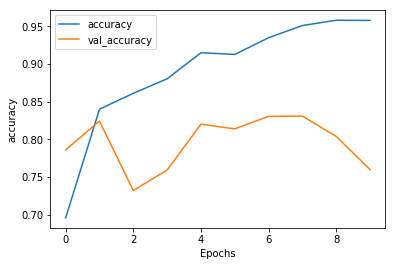

In [0]:
plot_graphs(history, 'accuracy')

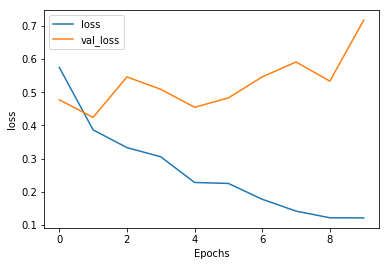

In [0]:
plot_graphs(history, 'loss')

# 2개 LSTM 레이어

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 542s 1s/step - loss: 0.5207 - accuracy: 0.7364 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
 46/391 [==>...........................] - ETA: 5:38 - loss: 0.4070 - accuracy: 0.8271

In [0]:
model.save("my_model2.h5")
new_model = keras.models.load_model('my_model2.h5')

In [0]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

In [0]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

In [0]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)